# My first Chatbot with Langgraph

In [32]:
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [33]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [34]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [35]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

api_key = os.getenv("GroqAPI")
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=api_key)

In [36]:
#node functionality
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [37]:
graph_builder=StateGraph(State)
## its a chatbot node 
graph_builder.add_node("Myllm Chatbot",chatbot)
## these are the edges start and end

graph_builder.add_edge(START, "Myllm Chatbot")
graph_builder.add_edge("Myllm Chatbot", END)

## compile the graph
graph=graph_builder.compile()
graph_builder=StateGraph(State)

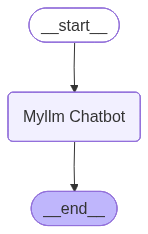

In [38]:
##visualize the Graph

from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [39]:
response=graph.invoke({"messages":"Hi"})

In [40]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [41]:
for event in graph.stream({"messages":"Hi How are you"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm always happy to chat and help with any questions or topics you'd like to discuss. How about you? How's your day going?


# Use tools in Langgraph

In [42]:
from langchain_tavily import TavilySearch
tool = TavilySearch(tavily_api_key=os.getenv("TAVILY_API_KEY"), max_results=2)
tool.invoke("what is langgraph")


{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interaction

In [43]:
def multiply(a:int,b:int)->int:
    """mutiply a and b
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [44]:
tools=[tool,multiply]

In [45]:
llm_with_tools=llm.bind_tools(tools)

In [46]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000015A13AFAA80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000015A15423260>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input

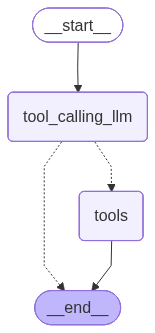

In [47]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph=builder.compile()

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
response=graph.invoke({"messages":"what is the recent ai news"})

In [49]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.7663815, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "On the same day this week, Anthropic and OpenAI launched competing frontier AI models – Opus 4.6 and GPT-5.3-Codex – that are both the new state-of-the-art in agentic AI. **OpenAI released GPT-5.3-Codex**, an agentic AI model designed to generate, debug, and reason over complex codebases across long-horizon tasks. **Kling AI released Kling 3.0**, an all-in-one multimodal video generation model supporting text, image, audio, and multi-shot video creation. Expanding their terminal-based Codex AI code tool into an app, **OpenAI released a native Codex application for macOS.** The app provides a dedicated desktop GUI interface for managing AI coding workflows, with voice dictation, slash c

In [50]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (wzr083b2j)
 Call ID: wzr083b2j
  Args:
    query: recent AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.7663815, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "On the same day this week, Anthropic and OpenAI launched competing frontier AI models – Opus 4.6 and GPT-5.3-Codex – that are both the new state-of-the-art in agentic AI. **OpenAI released GPT-5.3-Codex**, an agentic AI model designed to generate, debug, and reason over co

In [51]:
response=graph.invoke({"messages":"what is 2 multipy 3 is"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multipy 3 is
================================== Ai Message ==================================
Tool Calls:
  multiply (tw1qr4ged)
 Call ID: tw1qr4ged
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
